Notes for the results of pretraining on the pilot dataset.

# The loss during training
The training settings are as follows:
```
ViT model: base
Constant learning rate: 1e-5
Optimizer: AdamW (betas=(0.9, 0.95)) 
Clips gradient norm
Patch size: 16
Mask ratio: 0.75
Batch size: 64
Epochs: 100
Step size: 10 (batches)
```
Details please refer to `models_mae.py` and `test_train.py`.


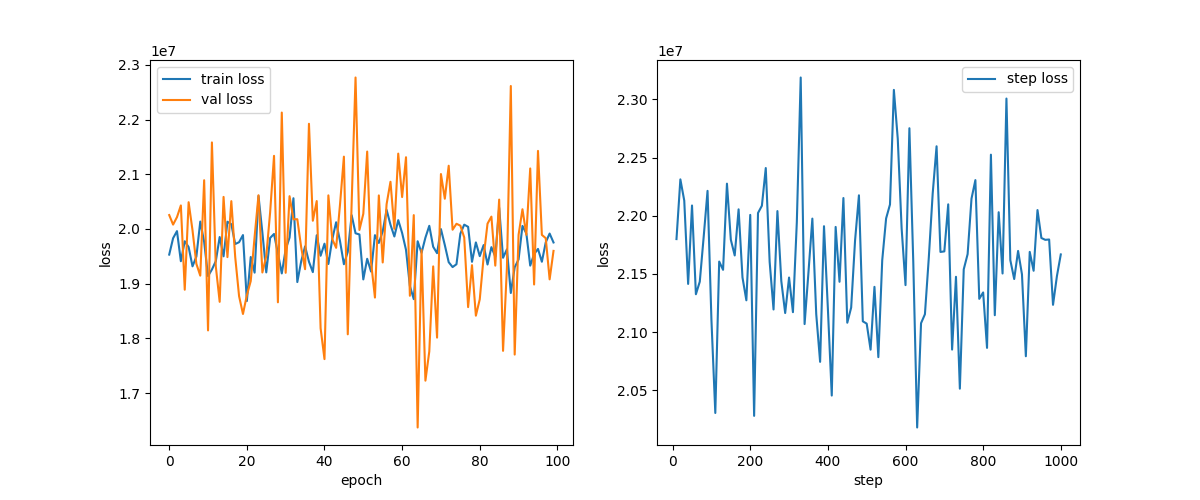

In [1]:
# display a png image
from IPython.display import Image
Image(filename='results/loss_20231130.png')

1. The training loss does not converge. The unconverging and high variance of validation loss is hence expected. At least, both losses are in the same order of magnitude.
1. The step loss varies more than the epoch loss. This is expected as the step loss is calculated on a smaller data subset (10 batches) comparing with an epoch (17 batches). Also, due to the small data amount (only 17 batches), the frequency of the step loss same as the epoch loss. This will be different when the training data is large enough, like more than 20 batches.
1. Is the loss too high? Seems be a bit too high... Let's check


# Analyze the loss

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import Generator
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from util.datasets import CustomImageDataset
from models_mae import mae_vit_base_patch16

In [3]:
dataset = CustomImageDataset('data/info_20231121.csv', 'data/spe')
data_train, data_val = random_split(dataset, [0.8, 0.2], generator=Generator().manual_seed(24))
batch_size = 64
dataloader = {
    'train':DataLoader(data_train, batch_size=batch_size, shuffle=True),
    'val':DataLoader(data_val, batch_size=batch_size, shuffle=True)
    }

print(f'Batch amount: {len(dataloader["train"])}')

Batch amount: 17


Spectrum shape: (2048,)


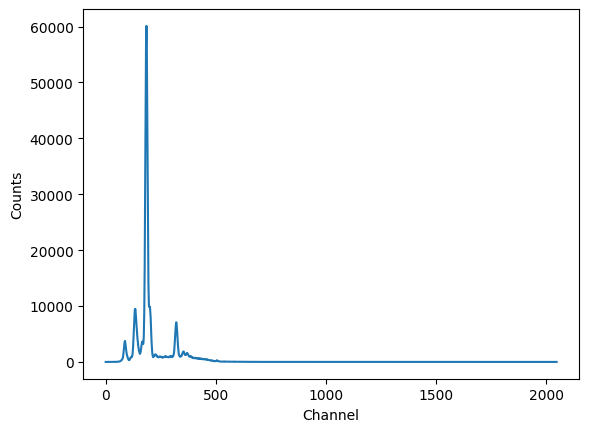

In [4]:
spe_arr = dataloader['train'].dataset[0]

print(f'Spectrum shape: {spe_arr.shape}')
plt.plot(spe_arr)
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.show()

In [5]:
model = mae_vit_base_patch16()
model.load_state_dict(torch.load('models/mae_vit_base_patch16_20231130.pth'))

<All keys matched successfully>

## Inconsistent loss!!
Even when `.eval()` is enabled, the loss is still inconsistent in every run using the same data. Where is the randomness from?

In [6]:
model.eval()

for _ in range(4):
    with torch.no_grad():
        spe = torch.from_numpy(spe_arr)
        loss, pred, mask = model(spe.unsqueeze(0).float())

    print(f'Loss: {loss}')

Loss: 21222156.0
Loss: 2751740.5
Loss: 22475344.0
Loss: 21337098.0


In [7]:
model.eval()

for _ in range(4):
    with torch.no_grad():
        torch.manual_seed(2)    # it works, so there is really randomness slipped through
        spe = torch.from_numpy(spe_arr)
        loss, pred, mask = model(spe.unsqueeze(0).float())

    print(f'Loss: {loss}')

Loss: 22395976.0
Loss: 22395976.0
Loss: 22395976.0
Loss: 22395976.0


In [8]:
# the input data?
old_spe = torch.from_numpy(spe_arr)
for _ in range(4):

    with torch.no_grad():
        spe = torch.from_numpy(spe_arr)

    print(spe.unsqueeze(0).float().equal(old_spe.unsqueeze(0).float()))
    old_spe = spe

True
True
True
True


After stopping using `next(iter(loader))` to generate validation spectrum, the loss is still inconsistent. The input data is checked to be the same every time I inference.

Inspired by this [post](https://discuss.pytorch.org/t/inconsistency-during-inference/112736/10), I found a randomness in the `forward` step, where `.eval()` doesn't work. It is the random masking of the input data, the function `random_masking`. Below you can see the mask varies in each run. After a small test that I fixed the seed of the random mask, the loss is consistent. The reason is found. It's not something that would crash the model. I'll simpy apply `torch.manual_seed` when I need consistent inference.

In [9]:
old_mask = torch.randn(1, 128)
for _ in range(4):

    with torch.no_grad():
        spe = torch.from_numpy(spe_arr)
        loss, pred, mask = model(spe.unsqueeze(0).float())

    print(mask.equal(old_mask))
    old_mask = mask

False
False
False
False


## Continue analyze

In [11]:
with torch.no_grad():
    torch.manual_seed(24)
    spe = torch.from_numpy(spe_arr)
    loss, pred, mask = model(spe.unsqueeze(0).float())

print(f'Loss: {loss}')
print(f'Prediction shape: {pred.shape}')
print(f'Mask shape: {mask.shape}')

Loss: 21068828.0
Prediction shape: torch.Size([1, 128, 16])
Mask shape: torch.Size([1, 128])


In [12]:
print(pred.shape)

# unpatch the predtion, remove the batch dimension, to numpy array
pred_un = model.unpatchify(pred)
print(pred_un.shape)

pred_un_arr = pred_un.squeeze(0).numpy()
print(pred_un_arr)

torch.Size([1, 128, 16])
torch.Size([1, 2048])
[ 0.3365178  -0.5000665  -0.43423414 ...  0.23163606  0.98668325
  0.6559639 ]


### Unpatchify

In [14]:
import numpy as np

mask_arr = mask.squeeze(0).numpy()
print(mask_arr)

mask_un_arr = np.array([])
for i in mask_arr:
    mask_un_arr = np.concatenate((mask_un_arr, np.repeat(i, 16)))

mask_un_arr = mask_un_arr.astype(int)
print(mask_un_arr.shape)

[1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1.
 0. 1. 0. 1. 0. 1. 0. 1.]
(2048,)


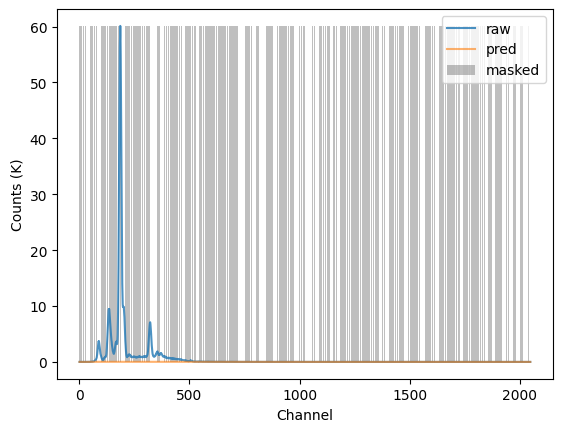

In [17]:
scale = .001
channel = np.arange(1, len(spe_arr)+1)
plt.bar(channel, mask_un_arr*(spe_arr.max()*scale), color='gray', alpha=0.5, label='masked')
plt.plot(channel, spe_arr*scale, alpha=.8, label='raw')
plt.plot(channel, pred_un_arr*scale, alpha=.6, label='pred')
plt.xlabel('Channel')
plt.ylabel('Counts (K)')
plt.legend()
plt.savefig('results/spectrum_20231130.png')

In [37]:
len(channel[mask_un_arr==1])

1536

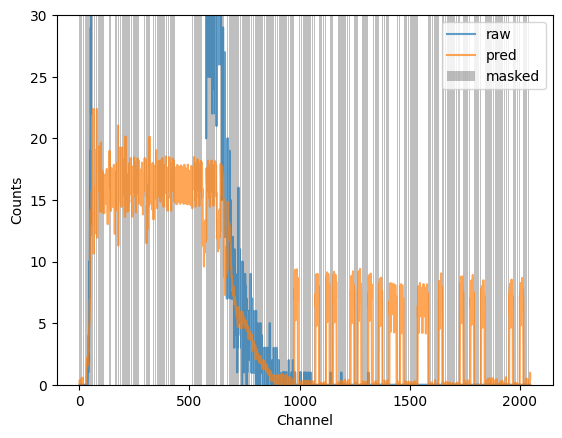

In [29]:
channel = np.arange(1, len(spe_arr)+1)
plt.bar(channel, mask_un_arr*30, color='gray', alpha=0.5, label='masked')
plt.plot(channel, spe_arr, alpha=0.7, label='raw')
plt.plot(channel, pred_un_arr, alpha=0.7, label='pred')
plt.ylim(0, 30)
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.legend()
plt.savefig('results/spectrum_zoom_20231130.png')

In [19]:
# 0: unmasked, 1: masked
print(
        'loss of the masked part ({}): {:.1f}'.format(
            mask_un_arr.sum(),
            ((pred_un_arr - spe_arr)**2 * mask_un_arr).sum() / mask_un_arr.sum()
        )
)

print(
        'loss of the unmasked part ({}): {:.1f}'.format(
            (mask_un_arr==0).sum(),
            ((pred_un_arr - spe_arr)**2 * (mask_un_arr==0)).sum() / (mask_un_arr==0).sum()
        )
)

loss of the masked part (1536): 21068827.6
loss of the unmasked part (512): 4946117.3


1.   The loss is correct based on the manual calculation.
1.   The prediction does try to fit the spectrum. It is not a random guess nor a constant. Only the magnitude is not enough.
1.   The unmasked part of the spectrum is predicted better than the masked part (5 times better). 
     This is expected as the model is trained on the unmasked part.
1.   The low counts part of the spectrum (the low ground after ca. 900 channel number) has larger loss on those unmasked part. 
     This is contrast to the expectation and the overall loss. 
1.   The loss is smaller at the spectrum ramps.


# Investigate data

In [57]:
import pandas as pd

arr_list = []
for arr in data_train:
    arr_list.append(arr)

data_df = pd.DataFrame(arr_list, columns=[str(col) for col in range(2048)])
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Columns: 2048 entries, 0 to 2047
dtypes: int64(2048)
memory usage: 16.8 MB


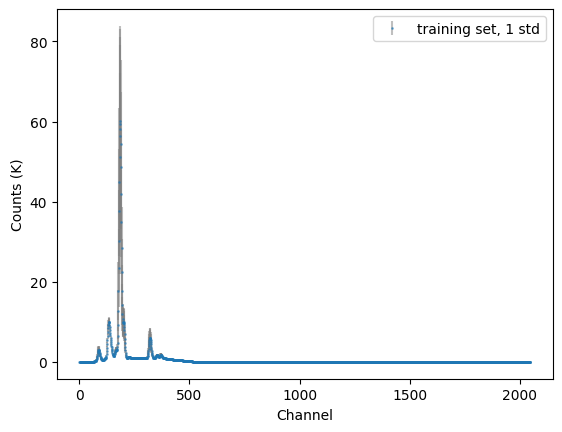

In [77]:
mean = data_df.apply(np.mean, axis=0)
std = data_df.apply(np.std, axis=0)

plt.errorbar(range(1, 2049), mean*scale, yerr=std*scale, 
             fmt='o', ecolor='gray', alpha=0.5,
             ms=1, label='training set, 1 std')
plt.xlabel('Channel')
plt.ylabel('Counts (K)')
plt.legend()
plt.savefig('results/spectrum_train_20231130.png')

## Short summary
-   I don't know what these observations tell. I will need to discuss with Hsuan-Tien.
-   Although the codes are fine and the prediction is not wild, the model has not convergered yet, not even overfitting. I think I should do hyperparameter tuning before the full-scale training.